In [127]:
# Dependencies

import pandas as pd
from pathlib import Path
import requests
from pprint import pprint
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import re
import math
from api_keys import ryan_weather_api_key
from api_keys import geoapify_key
import random
from scipy import stats

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

geoapify_key = "258bc892ef9140f1ad0a7d86fb1b2dcc"


In [5]:
# Store filepath in a variable
file_one = Path("Resources/us_counties_covid19_daily.csv")
file_two = Path("Resources/county_info_city.csv")

In [6]:
# Read our data file with the Pandas library
covid_df = pd.read_csv(file_one, encoding="ISO-8859-1")
county_df =pd.read_csv(file_two, encoding="ISO-8859-1")

In [47]:
# Show the first five rows.
covid_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [48]:
# Select rows in my date range
# Make a start date
start_date = '2020-09-01'

# Make an end date
end_date = '2020-11-30'

# Select DataFrame rows between two dates
mask = (covid_df['date'] > start_date) & (covid_df['date'] <= end_date)
fall_covid_df = covid_df.loc[mask]

# Show DataFrame
fall_covid_df

,date,county,state,fips,cases,deaths
492429,2020-09-02,Autauga,Alabama,1001.0,1452,24.0
492430,2020-09-02,Baldwin,Alabama,1003.0,4583,42.0
492431,2020-09-02,Barbour,Alabama,1005.0,768,7.0
492432,2020-09-02,Bibb,Alabama,1007.0,562,8.0
492433,2020-09-02,Blount,Alabama,1009.0,1308,11.0
...,...,...,...,...,...,...
784205,2020-11-30,Sweetwater,Wyoming,56037.0,1888,6.0
784206,2020-11-30,Teton,Wyoming,56039.0,1644,2.0
784207,2020-11-30,Uinta,Wyoming,56041.0,1070,4.0
784208,2020-11-30,Washakie,Wyoming,56043.0,440,8.0


In [109]:
# Combine Seat and State to get a city, state format
cols = ['Seat', 'State']
county_df['combined'] = county_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)

# Show new dataframe
county_df.head()

,State,County FIPS Code,County or Equivalent,Seat,combined
0,Alabama,1001,Autauga County,Prattville,"Prattville, Alabama"
1,Alabama,1003,Baldwin County,Bay Minette,"Bay Minette, Alabama"
2,Alabama,1005,Barbour County,Clayton,"Clayton, Alabama"
3,Alabama,1007,Bibb County,Centreville,"Centreville, Alabama"
4,Alabama,1009,Blount County,Oneonta,"Oneonta, Alabama"


In [146]:
# Select 500 random cities from the county dataframe
random_cities_df = county_df.sample()

# Show new dataframe
random_cities_df.head()

,State,County FIPS Code,County or Equivalent,Seat,combined
2195,Oklahoma,40143,Tulsa County,Tulsa,"Tulsa, Oklahoma"


In [147]:
# Get list of cities
cities_list = random_cities_df['combined']
cities = []
for city in cities_list:
    cities.append(city)

# Set the API base URL
geo_url = "https://api.geoapify.com/v1/geocode/search"
weather_url = "https://api.openweathermap.org/data/3.0/onecall/timemachine?"
units = "metric"

# Define an empty list to fetch the weather data for each city
city_data = []

# Loop through all the cities in our list to fetch weather data
for city in cities:

    # Set up GeoApify parameters
    params = {
        "text": city,
        "apiKey": geoapify_key
    }

    # Run request
    geo_response = requests.get(geo_url, params=params).json()

    # Get latitude and longitude of each city
    lat = geo_response['features'][0]['geometry']['coordinates'][1]
    lon = geo_response['features'][0]['geometry']['coordinates'][0]

    # Get dates
    fall_dates = fall_covid_df['date'].unique()

    # Set up OpenWeather parameters
    
    for date in fall_dates:
        unix_time = math.trunc(int(pd.Timestamp(date).timestamp()))
        url = f"{weather_url}lat={lat}&lon={lon}&dt={unix_time}&units={units}&appid={ryan_weather_api_key}"

        # Run request
        city_response = requests.get(url).json()

        # Get all 90 temperatures
        temp = city_response['data'][0]['temp']

        
        city_data.append({
            'date' : date,
            'Temp' : temp
        })

In [148]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Show new dataframe
city_data_df

,date,Temp
0,2020-09-02,23.71
1,2020-09-03,27.39
2,2020-09-04,30.69
3,2020-09-05,30.54
4,2020-09-06,30.62
...,...,...
85,2020-11-26,7.88
86,2020-11-27,13.58
87,2020-11-28,10.37
88,2020-11-29,8.38


In [149]:
# Average cases per date
avg_cases_df = fall_covid_df.groupby(by=['date']).mean()

In [150]:
# Reset index and combine average cases with the temperature data
avg_cases_df = avg_cases_df.reset_index()
combined = pd.merge(city_data_df, avg_cases_df, how='left', on='date')

In [116]:
# Creating an exponential regress
x = [i for i in range(1,91)]
y = avg_cases_df['cases']
fit = np.polyfit(x, np.log(y), 1)
one =round(fit[0],2)
two = round(math.exp(fit[1]), 2)
line_eq = f"y = {two} * e ^ {one} x"
line = [two * (math.exp(one * i)) for i in x]

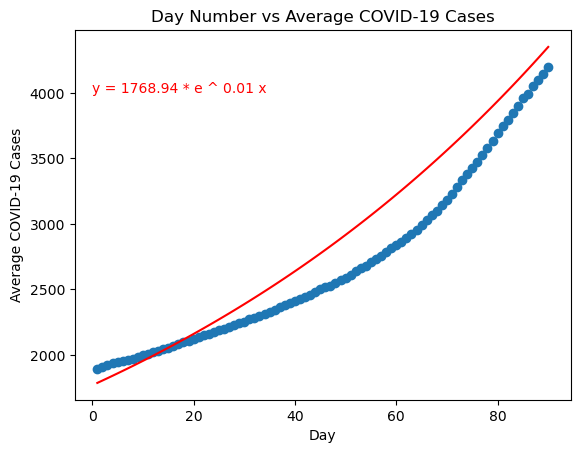

In [117]:
# Ploting data
plt.scatter([i for i in range(1,91)], avg_cases_df['cases'])
plt.plot(x,line, color='red')
plt.annotate(line_eq, (0, 4000), color='red')
plt.xlabel('Day')
plt.ylabel('Average COVID-19 Cases')
plt.title('Day Number vs Average COVID-19 Cases')
plt.show()

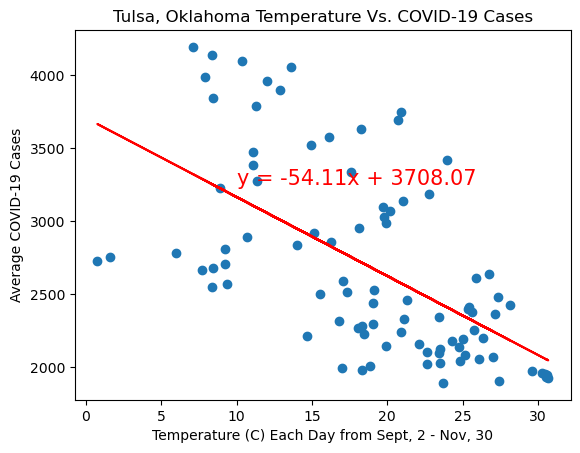

-0.5957648772950248


In [153]:
city_temp = combined['Temp']
city_cases= combined['cases']

p_slope, p_int, p_r, p_p, p_std_err = stats.linregress(city_temp, city_cases)
p_fit = p_slope * city_temp + p_int

line_equation = "y = " + str(round(p_slope,2)) + "x + " + str(round(p_int,2))

plt.scatter(city_temp, city_cases)
plt.plot(city_temp, p_fit, color='r')
plt.annotate(line_equation,(10,3250),fontsize=15,color="red")
plt.xlabel('Temperature (C) Each Day from Sept, 2 - Nov, 30')
plt.ylabel('Average COVID-19 Cases')
plt.title('Tulsa, Oklahoma Temperature Vs. COVID-19 Cases')
plt.show()
print(p_r)